Théo Ripoll - Bastien Pouessel - Tom Genlis - Quentin Fisch - Arnaud Baradat

# Rapport Very Large Graph

## Clique Finding Algorithms Benchmark Analysis

### 1. Graph Representation using networkx

We will be using the NetworkX library for graph representation.

In [1]:
import itertools
import networkx as nx
import matplotlib.pyplot as plt
from more_itertools import powerset
import time

Using NetworkX, we will be able to easily proceduraly generate random graphs with a set number of nodes and a set probability of edges, using the Erdos-Renyi algorithm provided by NetworkX.

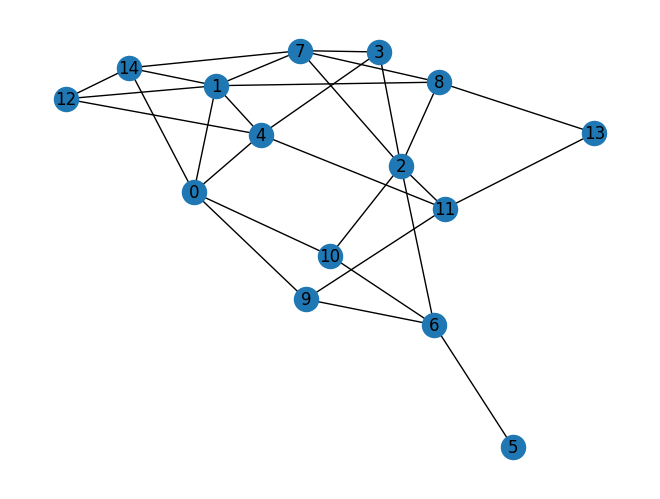

In [2]:
# use networkx to generate a random graph erdos_renyi_graph
# with a set number of nodes and a set probability of edges
G = nx.erdos_renyi_graph(15, 0.3, seed=1)

# use networkx to draw the graph
nx.draw(G, with_labels=True)

# show the graph
plt.show()

We next delve into the realm of clique finding algorithms, focusing on the contrast between non-parallelized and parallelized approaches.

Non-parallelized algorithms, such as the Naive, Bron Kerbosch, and its variants, operate sequentially and are typically simpler but can be slower for large data sets.

Conversely, parallelized methods, which we will explore through enhanced versions of the Bron Kerbosch algorithm, leverage concurrent processing to improve efficiency, particularly in handling large-scale graph data.

### 2. No Parallelization

#### 2.1 Naive Implementation


In this section, we implement a basic, straightforward approach to find cliques in a graph. This method, termed as the 'Naive' algorithm, involves a simplistic and direct strategy without incorporating any advanced optimizations or heuristics. The goal here is to establish a baseline understanding of the problem and to have a reference point for the performance of more complex algorithms.

Here's the pseudocode implementation of the Naive algorithm:

```python
fonction recherche_clique(graphe G):
    n = nombre de sommets de G
    taille_max_clique = 0
    clique_max = ensemble vide
    
    pour chaque sous-ensemble S de sommets de G:
        si la taille de S > taille_max_clique et est_clique(G, S):
            taille_max_clique = taille de S
            clique_max = S
            
    retourner clique_max

fonction est_clique(graphe G, ensemble S):
    pour chaque paire de sommets v, w dans S:
        si v n'est pas adjacent à w dans G:
            retourner faux
    retourner vrai
```

In [3]:
def is_clique(G, S):
    for i in S:
        for j in S:
            if i != j and not G.has_edge(i, j):
                return False
    return True

def recherche_clique_naive(G):
    n = G.number_of_nodes()
    taille_max_clique = 0
    clique_max = set()
    
    for S in powerset(G.nodes()):
        if len(S) > taille_max_clique and is_clique(G, S):
            taille_max_clique = len(S)
            clique_max = S
            
    return clique_max

Test on a small graph G while comparing with the NetworkX implementation:

In [4]:
start_time = time.time()
clique_max = recherche_clique_naive(G)
print("Clique max (naive):", clique_max)
print("Temps d'exécution (naive):", time.time() - start_time)

start_time = time.time()
clique_max_netx = nx.approximation.max_clique(G)
print("Clique max (networkx):", clique_max_netx)
print("Temps d'exécution (networkx):", time.time() - start_time)

Clique max (naive): (0, 1, 4)
Temps d'exécution (naive): 0.019258499145507812
Clique max (networkx): {2, 3, 7}
Temps d'exécution (networkx): 0.0005280971527099609


#### 2.2 Bron Kerbosch

This segment focuses on implementing the Bron Kerbosch algorithm, a classic method for finding maximal cliques in a graph. Unlike its optimized versions, this implementation does not incorporate pivoting. The Bron Kerbosch algorithm is a recursive, backtracking approach known for its efficiency in identifying all maximal cliques within a graph. This implementation serves as a stepping stone to understanding more complex variations of the algorithm.

Here's the pseudocode version of the algorithm:

```python
algorithme BronKerbosch1(R, P, X)
    si P et X sont vides alors
        déclarer que R est une clique maximale
    pour tout sommet v dans P faire
        BronKerbosch1(R ⋃ {v}, P ⋂ N(v), X ⋂ N(v))
        P := P \ {v}
        X := X ⋃ {v}

BronKerbosch1(∅, V, ∅) //appel initial
```

In [5]:
def bron_kerbosh1(R, P, X, G):
    if not P and not X:
        return [R]
    else:
        cliques = []
        for v in P.copy():
            N = G.neighbors(v)
            cliques.extend(
                bron_kerbosh1(
                    R.union({v}),
                    P.intersection(N),
                    X.intersection(N),
                    G,
                )
            )
            P.remove(v)
            X.union({v})
        return cliques

def search_clique_bron_kerbosh1(G):
    return max(bron_kerbosh1(set(), set(G.nodes()), set(), G), key=len)

Test on a small graph G while comparing with the NetworkX implementation:

In [6]:
start_time = time.time()
clique_max = search_clique_bron_kerbosh1(G)
print("Clique max (bron_kerbosh1):", clique_max)
print("Temps d'exécution (bron_kerbosh1):", time.time() - start_time)

start_time = time.time()
clique_max_netx = nx.approximation.max_clique(G)
print("Clique max (networkx):", clique_max_netx)
print("Temps d'exécution (networkx):", time.time() - start_time)

Clique max (bron_kerbosh1): {0, 1, 4}
Temps d'exécution (bron_kerbosh1): 0.0
Clique max (networkx): {2, 3, 7}
Temps d'exécution (networkx): 0.0020515918731689453


#### 2.3 Bron Kerbosch Pivot


In this part of our analysis, we enhance the basic Bron Kerbosch algorithm by incorporating a pivoting mechanism. Pivoting significantly optimizes the algorithm's performance by reducing the number of recursive calls needed to find maximal cliques. This version of the algorithm strategically chooses a 'pivot' vertex to minimize the search space, thereby improving the efficiency of clique finding in larger or more complex graphs.

Here's the pseudocode version of the algorithm.

```python
algorithme BronKerbosch2(R, P, X)
    si P et X sont vides alors
        déclarer que R est une clique maximale
    choisir un sommet pivot u dans P ⋃ X
    pour tout sommet v dans P \ N(u) faire
        BronKerbosch2(R ⋃ {v}, P ⋂ N(v), X ⋂ N(v))
        P := P \ {v}
        X := X ⋃ {v}
```

In [7]:
def bron_kerbosh2(R, P, X, G):
    if not P and not X:
        return [R]
    pivot = P.union(X).pop()  # TODO: compare both pivots
    pivot = max(P.union(X), key=G.degree)
    N = G.neighbors(pivot)
    cliques = []
    for v in P.difference(N):
        N_v = G.neighbors(v)
        cliques.extend(
            bron_kerbosh2(
                R.union({v}),
                P.intersection(N_v),
                X.intersection(N_v),
                G,
            )
        )
        P.remove(v)
        X.union({v})

    return cliques

def search_clique_bron_kerbosh2(G):
    return max(bron_kerbosh2(set(), set(G.nodes()), set(), G), key=len)

Test on a small graph G while comparing with the NetworkX implementation:

In [8]:
start_time = time.time()
clique_max = search_clique_bron_kerbosh2(G)
print("Clique max (bron_kerbosh2):", clique_max)
print("Temps d'exécution (bron_kerbosh2):", time.time() - start_time)

start_time = time.time()
clique_max_netx = nx.approximation.max_clique(G)
print("Clique max (networkx):", clique_max_netx)
print("Temps d'exécution (networkx):", time.time() - start_time)

Clique max (bron_kerbosh2): {0, 1, 4}
Temps d'exécution (bron_kerbosh2): 0.0
Clique max (networkx): {2, 3, 7}
Temps d'exécution (networkx): 0.0


#### 2.4 Bron Kerbosch Pivot and Degenerescence


The next step in our exploration of clique-finding algorithms involves further optimizing the Bron Kerbosch algorithm by incorporating degeneracy ordering. This method enhances the efficiency of the algorithm by ordering the vertices in a way that reduces the search space more effectively than the standard Bron Kerbosch algorithm, even with pivoting. The concept of degeneracy ordering is based on the principle of processing vertices with the smallest degree first, thereby simplifying the problem progressively.

Here's the pseudocode version of the algorithm.

```python
algorithme BronKerbosch3(G)
    P = V(G)
    R = Ø
    X = Ø
    pour tout sommet v visités dans un ordre de dégénérescence de G faire
        BronKerbosch2({v}, P ⋂ N(v), X ⋂ N(v))
        P := P \ {v}
        X := X ⋃ {v}
```

Description the degenerescence ordering.
- Initialiser la liste de sortie L à la liste vide.
- Calculer une valeur dv pour chaque sommet v de G, qui est le nombre de voisins de v qui n'est pas déjà dans L (initialement, il s'agit donc du degré des sommets dans G).
- Initialiser un tableau D tel que D[i] contienne la liste des sommets v qui ne sont pas déjà dans L pour lesquels dv = i.
- Initialiser la valeur k à 0.
- Répéter n fois:
    - Parcourir les cellules du tableau D[0], D[1], ... jusqu'à trouver un i pour lequel D[i] est non-vide.
    - Mettre k à max(k,i).
    - Sélectionner un sommet v de D[i], ajouter v en tête de L et le retirer de D[i].
    - Pour chaque voisin w de v qui n'est pas déjà dans L, retirer une unité de dw et déplacer w de la cellule de D correspondant à la nouvelle valeur de dw.

In [9]:
def degen(G):
    ordering = []
    deg = dict(G.degree())
    while deg:
        v = min(deg, key=deg.get)
        ordering.append(v)
        del deg[v]
        for w in G.neighbors(v):
            if w in deg:
                deg[w] -= 1
    return ordering


def bron_kerbosh3(G):
    R = set()
    P = set(G.nodes())
    X = set()
    cliques = []
    for v in degen(G):
        N = G.neighbors(v)
        cliques.extend(
            bron_kerbosh2(
                R.union({v}),
                P.intersection(N),
                X.intersection(N),
                G,
            )
        )
        P.remove(v)
        X.union({v})
    return cliques

def search_clique_bron_kerbosh3(G):
    return max(bron_kerbosh3(G), key=len)

Test on a small graph G while comparing with the NetworkX implementation.

In [10]:
start_time = time.time()
clique_max = search_clique_bron_kerbosh3(G)
print("Clique max (bron_kerbosh3):", clique_max)
print("Temps d'exécution (bron_kerbosh3):", time.time() - start_time)

start_time = time.time()
clique_max_netx = nx.approximation.max_clique(G)
print("Clique max (networkx):", clique_max_netx)
print("Temps d'exécution (networkx):", time.time() - start_time)

Clique max (bron_kerbosh3): {2, 3, 7}
Temps d'exécution (bron_kerbosh3): 0.0
Clique max (networkx): {2, 3, 7}
Temps d'exécution (networkx): 0.0061304569244384766


### 2.5 Benchmark and Analysis

Now, let's compare the performance of the different algorithms we have implemented on a range of graphs of increasing node sizes. We will then run each algorithm on these graphs and compare their performance on a graph.

In [11]:
import networkx as nx
import matplotlib.pyplot as plt
import time
import random
import tqdm
from tqdm import tqdm, trange

def generate_random_graph(node_count, edge_prob):
    """
    Generates a random graph with a given number of nodes and probability of edge creation.
    """
    return nx.erdos_renyi_graph(node_count, edge_prob)

def benchmark_clique_search_functions(functions, node_counts, edge_prob=0.5):
    """
    Benchmarks a list of clique search functions on randomly generated graphs with varying node counts.
    Plots the execution time of each function against the node count.
    """
    # Store execution times for each function and node count
    execution_times = {func.__name__: [] for func in functions}

    for node_count in tqdm(node_counts):
        # Generate a random graph
        G = generate_random_graph(node_count, edge_prob)

        for func in functions:
            start_time = time.time()
            if node_count > 15 and (func.__name__ == 'recherche_clique_naive' or func.__name__ == 'recherche_clique_naive_pool'):
                execution_times[func.__name__].append(float('inf'))
                continue

            func(G)  # Execute the function with the graph
            end_time = time.time()

            # Calculate and store the execution time
            execution_times[func.__name__].append(end_time - start_time)

    return execution_times

In [17]:
import numpy as np

functions = [
    recherche_clique_naive,
    search_clique_bron_kerbosh1,
    search_clique_bron_kerbosh2,
    search_clique_bron_kerbosh3
]

# Benchmark with a range of node counts exponentially spaced
node_counts = np.unique(np.power(1.34, np.arange(1, 20)).astype(int))
print(node_counts)

[  1   2   3   4   5   7  10  13  18  25  33  44  60  80 108 144 194 260]


In [14]:
# # load execution times
# import pickle
# with open('execution_times.pickle', 'rb') as f:
#     execution_times = pickle.load(f)

In [ ]:
execution_times = benchmark_clique_search_functions(functions, node_counts)

In [ ]:
# save execution times
import pickle
with open('execution_times.pickle', 'wb') as f:
    pickle.dump(execution_times, f)

In [18]:
from matplotlib.ticker import ScalarFormatter

def benchmark_plotting(node_counts, execution_times):
    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    for func_name, times in execution_times.items():
        plt.plot(node_counts, times, label=func_name)
    
    plt.yscale('log')
    plt.xscale('log', base=1.34)
    for axis in [ax.xaxis, ax.yaxis]:
        s = ScalarFormatter()
        s.set_scientific(False)
        axis.set_major_formatter(s)
    
    plt.xticks(node_counts[1:])
    plt.xlim(node_counts[5] / 1.5, node_counts[-1] * 1.5)

    plt.xlabel('Node Count')
    plt.ylabel('Execution Time (seconds)')
    plt.title('Clique Search Function Benchmarks')
    plt.legend()
    plt.grid(True)
    plt.show()

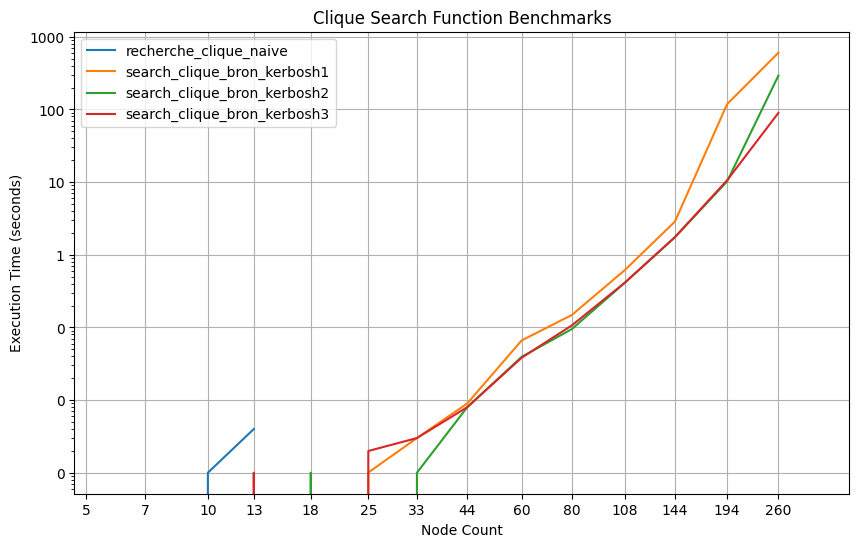

In [19]:
benchmark_plotting(node_counts, execution_times)

### 3. Parallelization


#### 3.1 Selection of Algorithm for Parallelization


In our analysis of various clique-finding algorithms, the Bron Kerbosch algorithm with pivoting and degeneracy ordering emerged as the best performing non-parallelized method.

This decision to parallelize this specific version was driven by its superior performance in previous benchmarks. The inclusion of both pivoting and degeneracy ordering in this algorithm significantly improved its efficiency, making it the ideal candidate for parallelization. Pivoting reduced the search space dramatically, while degeneracy ordering ensured an even more efficient exploration of the graph. These features not only enhanced its performance in terms of speed but also reduced computational complexity, making it the most promising version for adapting into a parallelized framework.

The aim is to leverage these inherent efficiencies while scaling up the algorithm's capability to handle larger and more complex graphs through parallel processing.

#### 3.2 Multithread


In this phase of our study, we focus on implementing a multithreaded version of the Bron Kerbosch algorithm with pivoting and degeneracy ordering. The objective here is to adapt the algorithm to run across multiple threads, thereby dividing the workload and potentially speeding up the process. Multithreading allows different parts of the algorithm to execute concurrently, making use of available CPU cores. This approach aims to harness the power of modern multi-core processors to enhance the performance of the clique finding task, especially beneficial when dealing with large and complex graphs.

However in Python, multithreading is not efficient because of the Global Interpreter Lock (GIL) which prevents multiple threads from executing Python bytecodes at once. This means that multithreading is not the best approach to parallelize Python code, but it is still interesting to see the performance difference.

#### 3.2.A Naive

In [20]:
import threading
import queue
import os
from concurrent.futures import ThreadPoolExecutor, as_completed

def is_clique(G, S):
    for i in S:
        for j in S:
            if i != j and not G.has_edge(i, j):
                return (False, S, 0)
    return (True, S, len(S))

def wrapper(arg):
    return is_clique(*arg)

def recherche_clique_naive_pool(G):
    n = G.number_of_nodes()
    taille_max_clique = 0
    clique_max = set()
    
    with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
        futures = [executor.submit(wrapper, (G, S)) for S in powerset(G.nodes())]
        for future in as_completed(futures):
            l = future.result()[2]
            S = future.result()[1]
            if l > taille_max_clique:
                taille_max_clique = l
                clique_max = S
            
    return clique_max

#### 3.2.B Bron Kerbosch Pivot and Degenerescence

In [21]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import os

def bron_kerbosh3_pool(G):
    R = set()
    P = set(G.nodes())
    X = set()
    cliques = []
    with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
        futures = [executor.submit(bron_kerbosh2, R.union({v}), P.intersection(G.neighbors(v)), X.intersection(G.neighbors(v)), G) for v in degen(G)]
        for future in tqdm(as_completed(futures)):
            cliques.extend(future.result())
    return cliques

def search_clique_bron_kerbosh3_pool(G):
    return max(bron_kerbosh3_pool(G), key=len)

In [22]:
clique_max = search_clique_bron_kerbosh3_pool(G)
print("Clique max (bron_kerbosh3):", clique_max)
print("Clique max (networkx):", clique_max_netx)

15it [00:00, ?it/s]

Clique max (bron_kerbosh3): {10, 2, 6}
Clique max (networkx): {2, 3, 7}


In [90]:
# # load execution times pool
# import pickle
# with open('execution_times_pool.pickle', 'rb') as f:
#     execution_times_pool = pickle.load(f)

In [23]:
functions_pool = [
    recherche_clique_naive_pool,
    search_clique_bron_kerbosh3_pool
]
execution_times_pool = benchmark_clique_search_functions(functions_pool, node_counts)

1it [00:00, ?it/s]/18 [00:00<?, ?it/s]
2it [00:00, ?it/s]
3it [00:00, ?it/s]
4it [00:00, ?it/s]
5it [00:00, 623.78it/s]
7it [00:00, ?it/s]
10it [00:00, ?it/s]
13it [00:00, ?it/s]18 [00:00<00:00, 40.49it/s]
18it [00:00, ?it/s]
25it [00:00, 23595.32it/s]
33it [00:00, ?it/s]
44it [00:00, ?it/s]
60it [00:00, ?it/s]/18 [00:00<00:00, 15.78it/s]
80it [00:00, ?it/s]
108it [00:00, 288.07it/s]
144it [00:12, 11.89it/s]00:15<00:01,  2.11it/s]
194it [01:45,  1.84it/s]00:21<00:04,  2.49s/it]
260it [11:42,  2.70s/it]02:14<00:19, 19.30s/it]
100%|██████████| 18/18 [14:23<00:00, 47.95s/it] 


In [24]:
# save execution times
import pickle
with open('execution_times_pool.pickle', 'wb') as f:
    pickle.dump(execution_times_pool, f)

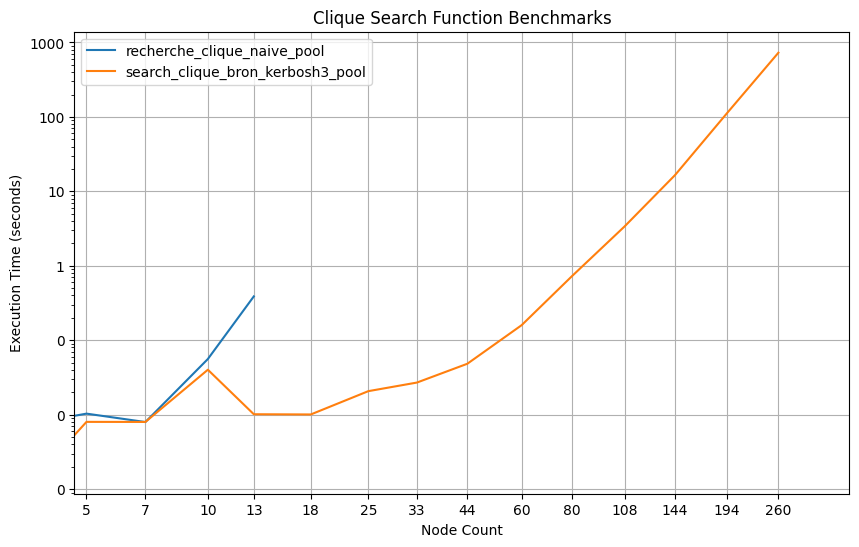

In [25]:
benchmark_plotting(node_counts, execution_times_pool)

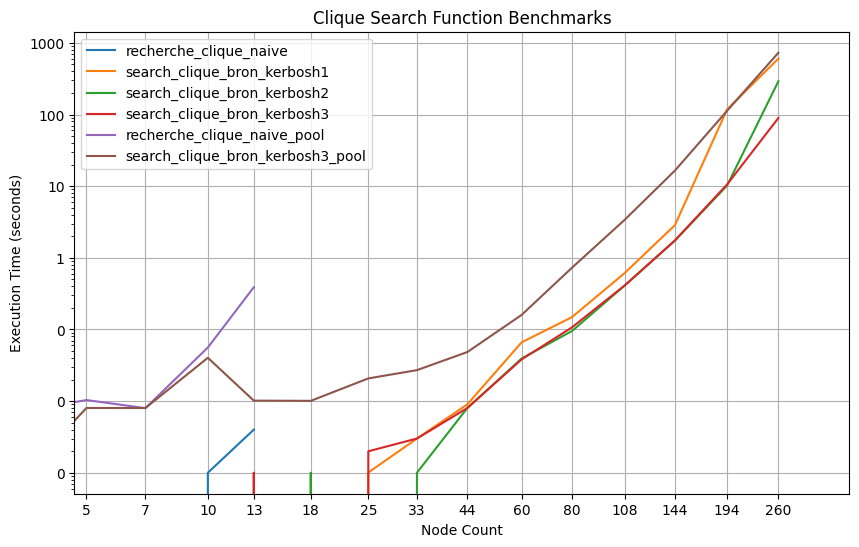

In [26]:
# concat execution times
total_execution_times = {}
for func_name, times in execution_times.items():
    total_execution_times[func_name] = times
for func_name, times in execution_times_pool.items():
    total_execution_times[func_name] = times

benchmark_plotting(node_counts, total_execution_times)

#### 3.3 PySpark Local


In this step of the project, we adapt the Bron Kerbosch algorithm with pivoting and degeneracy ordering to run on a local PySpark setup.

PySpark, the Python API for Apache Spark, offers a robust framework for distributed computing, allowing us to scale the algorithm beyond the limitations of single-machine processing. By migrating the algorithm to PySpark, we aim to distribute the computational tasks across multiple nodes, even in a local environment.

This adaptation is crucial for handling larger datasets and more complex graph structures, where the computational load can be significant. Utilizing PySpark's capabilities, such as resilient distributed datasets (RDDs) and its distributed processing engine, we can potentially achieve greater efficiency and scalability.

The focus here is not only on parallelizing the algorithm but also on optimizing it for a distributed computing environment, leveraging PySpark's tools and features for effective large-scale data processing.

#### 3.4 PySpark Cluster


The next progression in our analysis involves scaling the PySpark implementation to run on a cluster. This step is crucial for harnessing the full potential of distributed computing.

By deploying the algorithm on a cluster, we can distribute the processing load across multiple nodes, significantly enhancing the algorithm's ability to handle very large and complex graph datasets. The cluster environment provides a more robust and flexible platform, allowing the algorithm to operate in a truly distributed manner, potentially leading to substantial improvements in processing speed and efficiency. 

This stage demonstrates the practical applicability of the algorithm in a high-performance computing environment, highlighting the benefits of distributed computing in graph analytics.

### 4. Conclusion

- **Summary**: Recapitulate key findings from the benchmarks.
- **Insights**: Discuss insights gained from comparing non-parallelized and parallelized versions.
- **Future Work**: Suggest areas for further research or improvements in clique finding algorithms.
